In [112]:
# importing a packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM ,Dense, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [101]:
# Defining a the sysmbol of TATA Steel from Yahoo finanace
tataSteel_symbol = 'TATASTEEL.NS'

# Fetching a live data of TATA Steel share
tataSteel_ticker = yf.Ticker(tataSteel_symbol)

# Get historical data of TATA steel last 10y data with a 1 day interval
tataSteel_DF = tataSteel_ticker.history(period='10y', interval='1d')

# Sample of data
tataSteel_DF.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-07-21 00:00:00+05:30,19.319882,19.590498,19.188000,19.275351,46076321,0.0,0.0
2014-07-22 00:00:00+05:30,19.422649,19.499722,19.025290,19.258224,42242187,0.0,0.0
2014-07-23 00:00:00+05:30,19.371266,19.386681,18.859151,18.996172,44291652,0.0,0.0
2014-07-24 00:00:00+05:30,19.080098,19.573372,18.948216,19.460331,67054521,0.0,0.0
2014-07-25 00:00:00+05:30,19.525414,19.674424,18.908821,19.100651,61935762,0.0,0.0


In [102]:
def preProcessing(copyOfDataframe):
    '''
        Excluding divident and stock splits because it always zero
    '''
    copyOfDataframe = copyOfDataframe.drop(columns=['Dividends', 'Stock Splits'], errors='ignore')
    
    # Extrating a Number of year, month, week and day
    copyOfDataframe['Year']  = copyOfDataframe.index.year
    copyOfDataframe['Month'] = copyOfDataframe.index.month
    copyOfDataframe['Week']  = copyOfDataframe.index.day_of_week
    copyOfDataframe['Day']  = copyOfDataframe.index.day
    
    # Dropping a origal Date column
    copyOfDataframe = copyOfDataframe.reset_index(drop=True)
    
    # Drop row with missing values
    copyOfDataframe = copyOfDataframe.dropna()
    
    # Reordering a columns values 
    copyOfDataframe = copyOfDataframe[['Year', 'Month', 'Week','Day','Open','High','Low', 'Close', 'Volume']]
    
    return copyOfDataframe

In [103]:
tataSteel_DF = preProcessing(tataSteel_DF.copy())
tataSteel_DF

,Year,Month,Week,Day,Open,High,Low,Close,Volume
0,2014,7,0,21,19.319882,19.590498,19.188000,19.275351,46076321
1,2014,7,1,22,19.422649,19.499722,19.025290,19.258224,42242187
2,2014,7,2,23,19.371266,19.386681,18.859151,18.996172,44291652
3,2014,7,3,24,19.080098,19.573372,18.948216,19.460331,67054521
4,2014,7,4,25,19.525414,19.674424,18.908821,19.100651,61935762
...,...,...,...,...,...,...,...,...,...
2457,2024,7,4,12,170.199997,170.389999,168.009995,168.690002,33311402
2458,2024,7,0,15,168.690002,168.990005,165.800003,166.759995,32635187
2459,2024,7,1,16,167.800003,169.820007,166.699997,167.070007,26505901
2460,2024,7,3,18,167.610001,167.610001,164.440002,166.360001,36568852


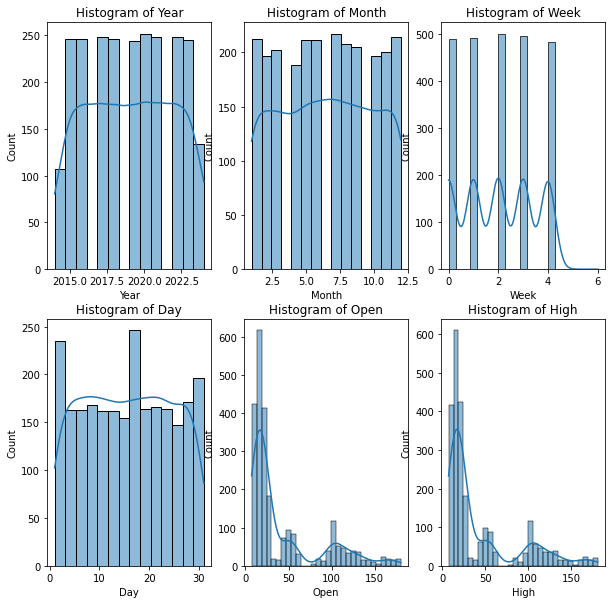

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))

for i, (colm, ax) in enumerate(zip(tataSteel_DF.columns, ax.flatten())):
  sns.histplot(data=tataSteel_DF, x=colm, ax=ax, kde=True)
  ax.set_title(f'Histogram of {colm}')

In [108]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tataSteel_DF)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Create sequence of 'time_step' length
        y.append(data[i + time_step, 7])  # Predict the 'Close' price of the next time step
    return np.array(X), np.array(y)

time_step = 60  # Length of the time window
X, y = create_dataset(scaled_data, time_step)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape Data for Neural Network
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [138]:
model = Sequential()

# Layer one with Input Shape and Regulization
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))

# Second Layer with Regulization
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer with Regulization
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))

#Output Layer
model.add(Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 100)           44000     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)               

In [139]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
60/60 [==============================] - 8s 85ms/step - loss: 0.0083 - val_loss: 8.5574e-04
Epoch 2/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0016 - val_loss: 4.4266e-04
Epoch 4/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0011 - val_loss: 4.1484e-04
Epoch 6/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0010 - val_loss: 4.7571e-04
Epoch 7/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0010 - val_loss: 7.0115e-04
Epoch 9/10
60/60 [==============================] - 5s 83ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/10
60/60 [==============================] - 5s 83ms/step - loss: 9.1946e-04 - va

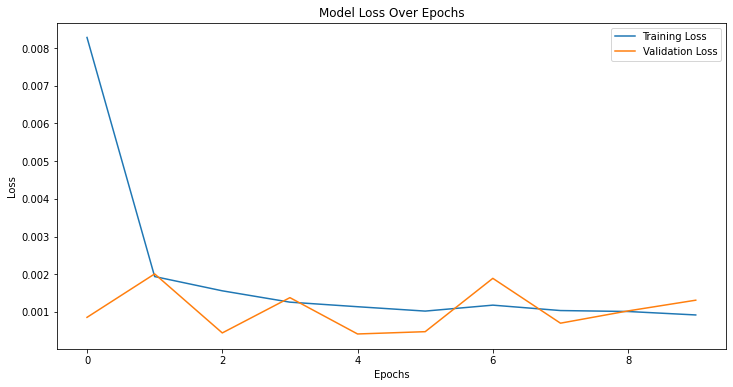

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [141]:
# Make Predictions
predictions = model.predict(X_test)

#Inverse Transform Predictions
predictions = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], tataSteel_DF.shape[1] - 1)), predictions)))

# Extract the closing price predictions
predictions = predictions[:, -1]

# Evaluate the Model
mse = mean_squared_error(scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], tataSteel_DF.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1], predictions)
print(f'Mean Squared Error: {mse}')

# Round predictions to 2 decimal points
predictions = np.round(predictions, 2)
print(predictions[:10])

16/16 [==============================] - 1s 23ms/step
Mean Squared Error: 541743713747959.56
[4.47335513e+07 7.13037629e+06 5.75592404e+07 1.43426483e+08
 6.77722206e+07 3.56400386e+08 4.02569000e+06 5.48116475e+07
 7.72764634e+07 1.76103712e+07]


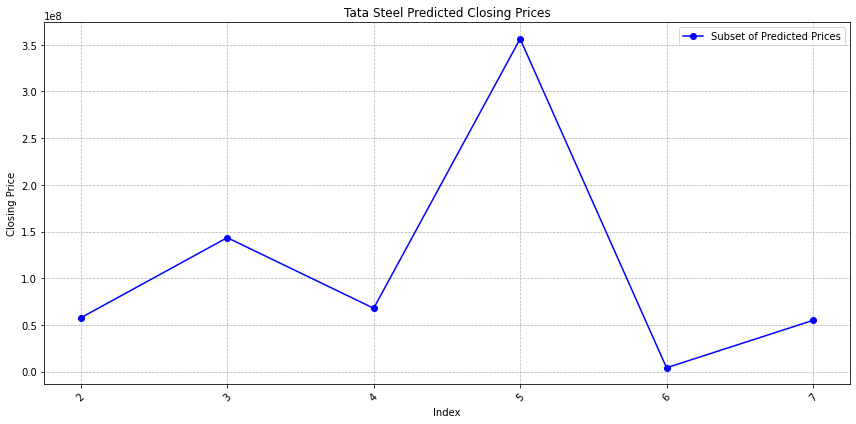

In [142]:
# Selecting specific range of index for clear ploting
start_index = 2
end_index = 7
tataSteel_DF_x = np.arange(start_index, end_index + 1)
tatasteel_predictions = predictions[start_index:end_index + 1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tataSteel_DF_x, tatasteel_predictions, marker='o', linestyle='-', color='b', label='Subset of Predicted Prices')

plt.title('Tata Steel Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()